In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

In [2]:
pd.__version__

'2.1.4'

In [3]:
df = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet")

In [4]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN


In [5]:
df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)

In [6]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

In [7]:
df.duration.describe(percentiles=[0.95,0.98,0.99])

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
50%      1.151667e+01
95%      3.646667e+01
98%      4.873333e+01
99%      5.725000e+01
max      1.002918e+04
Name: duration, dtype: float64

In [8]:
((df.duration >= 1 ) & (df.duration <=60)).mean()

0.9812202822125979

In [9]:
df = df[((df.duration >= 1 ) & (df.duration <=60))]

In [10]:
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']

In [11]:
df[categorical] = df[categorical].astype(str)

/tmp/ipykernel_35202/1767203464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


In [12]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                     object
DOLocationID                     object
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
duration                        float64
dtype: object

In [13]:
train_dicts = df[categorical ].to_dict(orient= 'records')

In [33]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [34]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

In [16]:
X_train.shape

(3009173, 515)

In [17]:
target = 'duration'
Y_train = df[target].values

In [18]:
Y_train

array([ 8.43333333,  6.31666667, 12.75      , ..., 24.51666667,
       13.        , 14.4       ])

In [19]:
lr = LinearRegression()
lr.fit(X_train,Y_train)

LinearRegression()

In [20]:
Y_pred = lr.predict(X_train)

/tmp/ipykernel_35202/2021408076.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y_pred, label = 'prediction')
/home/codespace/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_35202/2021408076.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level

<Axes: ylabel='Density'>

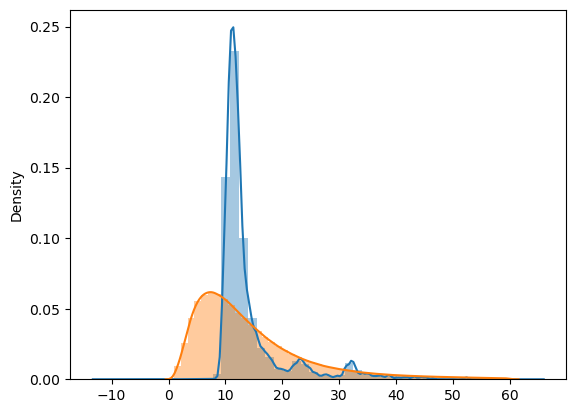

In [21]:
sns.distplot(Y_pred, label = 'prediction')
sns.distplot(Y_train, label = 'actual')

In [22]:
mean_squared_error(Y_train, Y_pred, squared= False)

7.649261930819891

In [23]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
    
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds()/60)
    
    df = df[((df.duration >= 1 ) & (df.duration <=60))]
    
    categorical = ['PULocationID','DOLocationID']
    # numerical = ['trip_distance']
    df[categorical] = df[categorical].astype(str)

    return df


In [24]:
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

In [25]:
len(df_val)

2855951

In [35]:
# train_dicts = df[categorical ].to_dict(orient= 'records')
# X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical ].to_dict(orient= 'records')
X_val = dv.transform(val_dicts)   

In [36]:
X_val.shape

(2855951, 515)

In [39]:
target = 'duration'
Y_val = df_val[target].values

In [40]:
Y_pred = lr.predict(X_val)
    
mean_squared_error(Y_val, Y_pred, squared= False)

7.811817675774269